In [35]:
#importing libraries
import numpy as np
from collections import Counter
import pandas as pd
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, log_loss,roc_auc_score

# for lightGBM
from lightgbm import LGBMClassifier

# for naive bayes
from sklearn.naive_bayes import GaussianNB

# for evaluation metrics
%run -i helper_functions.py

# for plotting graph
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# for multi-label classification
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from sklearn.multiclass import OneVsRestClassifier

In [2]:
selected_train = pd.read_csv('Data/selected_train.csv')
selected_train.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none,min_length_scaled,num_words_vs_length,exclamation_marks_vs_length,...,105,114,132,135,139,143,156,157,170,198
0,0,0,0,0,0,0,1,0.009393,0.181132,0.000000,...,-0.091320,-0.017755,0.003997,-0.199211,-0.109984,0.089084,0.012651,-0.019501,-0.091946,-0.113697
1,0,0,0,0,0,0,1,0.000723,0.160714,0.008929,...,-0.118445,0.039541,0.017522,0.001397,0.000094,0.021135,0.039308,-0.067295,-0.079366,-0.044959
2,0,0,0,0,0,0,1,0.007225,0.188841,0.000000,...,-0.131555,-0.060714,0.026459,-0.029582,-0.146134,0.109907,0.036539,-0.053628,0.027530,-0.211230
3,0,0,0,0,0,0,1,0.007948,0.175719,0.000000,...,-0.145382,-0.004285,-0.000706,-0.134984,-0.214832,0.177560,0.007675,-0.087473,0.106848,-0.015987
4,0,0,0,0,0,0,1,0.003613,0.208955,0.000000,...,0.007073,-0.204627,0.162032,0.013798,-0.221076,0.163578,-0.068310,-0.031184,-0.017280,0.038566


In [13]:
oversampled_train = pd.read_csv('Data/train_oversampled.csv')
oversampled_train.head()

,toxic,obscene,insult,none,min_length_scaled,num_words_vs_length,exclamation_marks_vs_length,num_unique_words_scaled,verbs_vs_length,num_uppercase_scaled,...,139,143,156,157,170,198,clean_text,threat,identity_hate,severe_toxic
0,0,0,0,1,0.009393,0.181132,0.000000,0.106329,0.041509,0.003426,...,-0.109984,0.089084,0.012651,-0.019501,-0.091946,-0.113697,explanation why the edits made under my userna...,0,0,0
1,0,0,0,1,0.000723,0.160714,0.008929,0.043038,0.026786,0.001612,...,0.000094,0.021135,0.039308,-0.067295,-0.079366,-0.044959,d'aww! he matches this background colour i am ...,0,0,0
2,0,0,0,1,0.007225,0.188841,0.000000,0.091139,0.038627,0.000806,...,-0.146134,0.109907,0.036539,-0.053628,0.027530,-0.211230,"hey man, i am really not trying to edit war. i...",0,0,0
3,0,0,0,1,0.007948,0.175719,0.000000,0.141772,0.036741,0.002217,...,-0.214832,0.177560,0.007675,-0.087473,0.106848,-0.015987,""" more i cannot make any real suggestions on i...",0,0,0
4,0,0,0,1,0.003613,0.208955,0.000000,0.027848,0.059701,0.000403,...,-0.221076,0.163578,-0.068310,-0.031184,-0.017280,0.038566,"you, sir, are my hero. any chance you remember...",0,0,0


In [3]:
selected_test = pd.read_csv('Data/selected_test.csv')
selected_test.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,min_length_scaled,num_words_vs_length,exclamation_marks_vs_length,num_unique_words_scaled,...,114,132,135,139,143,156,157,170,198,none
0,0,0,0,0,0,0,0.002890,0.166667,0.000000,0.032911,...,0.040738,-0.010083,-0.158238,-0.204194,0.116565,0.098296,-0.206160,0.046779,-0.036748,1
1,0,0,0,0,0,0,0.005058,0.187500,0.000000,0.015190,...,-0.013467,0.003550,-0.117174,-0.075475,0.043945,-0.148617,-0.350740,0.113815,-0.070907,1
2,0,0,0,0,0,0,0.000723,0.149554,0.002232,0.118987,...,-0.125080,0.045087,-0.119656,-0.274707,0.102546,0.100782,-0.107205,-0.050780,-0.098343,1
3,0,0,0,0,0,0,0.007225,0.169661,0.000000,0.070886,...,-0.023304,-0.005002,-0.281848,-0.157011,0.184323,0.067625,-0.066242,0.023737,-0.111269,1
4,0,0,0,0,0,0,0.003613,0.167665,0.000000,0.060759,...,0.055657,0.024936,-0.181419,-0.165707,0.194511,0.143557,-0.059017,0.136676,-0.004530,1


In [4]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
features = selected_train.columns[7:].tolist()
len(features)

41

## Naive Bayes (Gaussian)

### Baseline Naive Bayes (Binary Relevance)

In [16]:
import warnings
warnings.filterwarnings("ignore")

classifier_nb = BinaryRelevance(GaussianNB())
scores_nb = model_evaluation(classifier_nb, selected_train)

Starting fitting...
Evaluation Scores:
[0.8789284035719881, 0.5715483908737066, 0.6479011652393655, 0.5832717200061652, 0.7756063031698341, 0.9330046207881543]

Starting fitting...
Evaluation Scores:
[0.8796452967349753, 0.5602632421469866, 0.6506213398085988, 0.5785271449603704, 0.8333583591899076, 0.9307412214304145]

Starting fitting...
Evaluation Scores:
[0.8799899730525788, 0.5610676159107579, 0.6480900798175598, 0.5803843266590719, 0.7795086939329852, 0.9313953270246577]

Starting fitting...
Evaluation Scores:
[0.8788619414676945, 0.5510702237053057, 0.6545532892846883, 0.5762509102969147, 0.7510528127141824, 0.9311239191196757]

Starting fitting...
Evaluation Scores:
[0.8788619414676945, 0.5484806738562414, 0.6423670668953688, 0.5694796008298718, 0.7420354407658154, 0.9296580313213078]



In [17]:
scores_nb

,accuracy,precision_weighted,recall_weighted,f1_weighted,log_loss,roc_auc_weighted
0,0.878928,0.571548,0.647901,0.583272,0.775606,0.933005
1,0.879645,0.560263,0.650621,0.578527,0.833358,0.930741
2,0.879990,0.561068,0.648090,0.580384,0.779509,0.931395
3,0.878862,0.551070,0.654553,0.576251,0.751053,0.931124
4,0.878862,0.548481,0.642367,0.569480,0.742035,0.929658


### Baseline Naive Bayes (Classifier Chain)

In [9]:
import warnings
warnings.filterwarnings("ignore")

classifier_chain_nb = ClassifierChain(GaussianNB())
scores_chain_nb = model_evaluation(classifier_chain_nb, selected_train)

Starting fitting...
Evaluation Scores:
[0.8783957386808711, 0.5694449118581052, 0.6773831250877439, 0.5878255388701422, 0.6840991491494876, 0.9327575982707875]

Starting fitting...
Evaluation Scores:
[0.8795512941029016, 0.557767882585371, 0.6791886873303814, 0.5829251187272694, 0.6608664664315183, 0.9302710106938301]

Starting fitting...
Evaluation Scores:
[0.8788306072570032, 0.5574433457375569, 0.6747434435575826, 0.5837088858374886, 0.691096016677053, 0.9314488628620318]

Starting fitting...
Evaluation Scores:
[0.8786426019928558, 0.5510989597882777, 0.6818442976156277, 0.5814528773171644, 0.6679590716972084, 0.9313728498641484]

Starting fitting...
Evaluation Scores:
[0.8791126151532243, 0.5490535880193235, 0.6793882218410521, 0.5778370263406097, 0.6498304195299855, 0.9293278078492048]



In [10]:
scores_chain_nb

,accuracy,precision_weighted,recall_weighted,f1_weighted,log_loss,roc_auc_weighted
0,0.878396,0.569445,0.677383,0.587826,0.684099,0.932758
1,0.879551,0.557768,0.679189,0.582925,0.660866,0.930271
2,0.878831,0.557443,0.674743,0.583709,0.691096,0.931449
3,0.878643,0.551099,0.681844,0.581453,0.667959,0.931373
4,0.879113,0.549054,0.679388,0.577837,0.649830,0.929328


### Baseline Naive Bayes (Label Powerset)

In [11]:
import warnings
warnings.filterwarnings("ignore")

classifier_power_nb = LabelPowerset(GaussianNB())
scores_power_nb = model_evaluation(classifier_power_nb, selected_train)

Starting fitting...
Evaluation Scores:
[0.8661757794140686, 0.6018963033058127, 0.5305348869858206, 0.5504654741117929, 0.7594843403386139, 0.9425114002449541]

Starting fitting...
Evaluation Scores:
[0.8610014413736918, 0.6002020756700477, 0.5346379088701614, 0.5509261122076894, 0.7466070917604433, 0.9406350841787968]

Starting fitting...
Evaluation Scores:
[0.8634141755969167, 0.6069886709822372, 0.5313568985176739, 0.5551975161036182, 0.7396277985054824, 0.9405715287078221]

Starting fitting...
Evaluation Scores:
[0.8672996177226295, 0.5872768902083018, 0.5476874461361678, 0.5552266275495805, 0.7358029140335115, 0.941963894412374]

Starting fitting...
Evaluation Scores:
[0.6154352321865012, 0.6046932126909796, 0.529874213836478, 0.5491505479707515, 1.2631807856252, 0.9227793552186113]



In [12]:
scores_power_nb

,accuracy,precision_weighted,recall_weighted,f1_weighted,log_loss,roc_auc_weighted
0,0.866176,0.601896,0.530535,0.550465,0.759484,0.942511
1,0.861001,0.600202,0.534638,0.550926,0.746607,0.940635
2,0.863414,0.606989,0.531357,0.555198,0.739628,0.940572
3,0.867300,0.587277,0.547687,0.555227,0.735803,0.941964
4,0.615435,0.604693,0.529874,0.549151,1.263181,0.922779


### Store Results

In [18]:
scores_collection = pd.DataFrame({'model name': [], 'accuracy':[], 'precision_weighted':[], 'recall_weighted':[], 
                                      'f1_weighted':[], 'log_loss':[], 'roc_auc_weighted':[]})
scores_collection.loc[len(scores_collection)] = ['Naive Bayes with BinaryRelevance']+np.mean(scores_nb).values.tolist()
scores_collection.loc[len(scores_collection)] = ['Naive Bayes with ClassifierChain']+np.mean(scores_chain_nb).values.tolist()
scores_collection.loc[len(scores_collection)] = ['Naive Bayes with LabelPowerset']+np.mean(scores_power_nb).values.tolist()

In [19]:
scores_collection

,model name,accuracy,precision_weighted,recall_weighted,f1_weighted,log_loss,roc_auc_weighted
0,Naive Bayes with BinaryRelevance,0.879258,0.558486,0.648707,0.577583,0.776312,0.931185
1,Naive Bayes with ClassifierChain,0.878907,0.556962,0.678510,0.582750,0.670770,0.931036
2,Naive Bayes with LabelPowerset,0.814665,0.600211,0.534818,0.552193,0.848941,0.937692


In [20]:
scores_collection.to_csv('Naive Bayes Evaluation.csv', index=False)

## Gradient Boosting (LightGBM)

### Baseline LightGBM (Binary Relevance)

In [21]:
classifier_lgbm = BinaryRelevance(LGBMClassifier(random_state=0))
scores_lgbm = model_evaluation(classifier_lgbm, selected_train)

Starting fitting...
Evaluation Scores:
[0.9095723014256619, 0.7661104086979181, 0.6317562824652534, 0.6902118375574487, 0.312387173019109, 0.969663821936543]

Starting fitting...
Evaluation Scores:
[0.909914144262706, 0.7625046563312645, 0.628767318954435, 0.6875497122030292, 0.3132330605633174, 0.9678895619506587]

Starting fitting...
Evaluation Scores:
[0.9136429153349627, 0.7713182971086486, 0.632981755986317, 0.694427608151468, 0.302000586330098, 0.9697121298235039]

Starting fitting...
Evaluation Scores:
[0.9141129284953312, 0.7638229720617058, 0.6409077851192186, 0.695378422729532, 0.29264879265243215, 0.971196366840294]

Starting fitting...
Evaluation Scores:
[0.9104154916337658, 0.7588289819626245, 0.6187821612349914, 0.6797687514559946, 0.3079320387421403, 0.9677887055688228]



In [22]:
scores_lgbm

,accuracy,precision_weighted,recall_weighted,f1_weighted,log_loss,roc_auc_weighted
0,0.909572,0.766110,0.631756,0.690212,0.312387,0.969664
1,0.909914,0.762505,0.628767,0.687550,0.313233,0.967890
2,0.913643,0.771318,0.632982,0.694428,0.302001,0.969712
3,0.914113,0.763823,0.640908,0.695378,0.292649,0.971196
4,0.910415,0.758829,0.618782,0.679769,0.307932,0.967789


### Baseline LightGBM (Classifier Chain)

In [23]:
classifier_chain_lgbm = ClassifierChain(LGBMClassifier(random_state=0))
scores_chain_lgbm = model_evaluation(classifier_chain_lgbm, selected_train)

Starting fitting...
Evaluation Scores:
[0.9096349678834403, 0.748927783220423, 0.6427067246946512, 0.6891056507242154, 0.3386696064127461, 0.9661056623983522]

Starting fitting...
Evaluation Scores:
[0.9123895469073134, 0.748799204841491, 0.6399085844879303, 0.6876000045274068, 0.3320650450878651, 0.9651877194140769]

Starting fitting...
Evaluation Scores:
[0.9120135363790186, 0.759800880152979, 0.6466647662485747, 0.6975799485327236, 0.32658714649582193, 0.966304107432663]

Starting fitting...
Evaluation Scores:
[0.9087861126778216, 0.7435420091875927, 0.652111462223499, 0.6930643156256509, 0.32603409140926753, 0.9671959953142866]

Starting fitting...
Evaluation Scores:
[0.9114495205865765, 0.7494718523707353, 0.62778730703259, 0.6799671383506708, 0.3326472696605932, 0.964884440707312]



In [24]:
scores_chain_lgbm

,accuracy,precision_weighted,recall_weighted,f1_weighted,log_loss,roc_auc_weighted
0,0.909635,0.748928,0.642707,0.689106,0.338670,0.966106
1,0.912390,0.748799,0.639909,0.687600,0.332065,0.965188
2,0.912014,0.759801,0.646665,0.697580,0.326587,0.966304
3,0.908786,0.743542,0.652111,0.693064,0.326034,0.967196
4,0.911450,0.749472,0.627787,0.679967,0.332647,0.964884


### Baseline LightGBM (Label Powerset)

In [27]:
classifier_power_lgbm = LabelPowerset(LGBMClassifier(random_state=0))
scores_power_lgbm = model_evaluation(classifier_power_lgbm, selected_train)

Starting fitting...
Evaluation Scores:
[0.8612877957073476, 0.28087580813469787, 0.18685946932472272, 0.20384834981194794, 2.656264318716781, 0.5819596623046712]

Starting fitting...
Evaluation Scores:
[0.8977564705145077, 0.5879989362662261, 0.025567776031995428, 0.04880377222574344, 0.5299957465908226, 0.5124647179528453]

Starting fitting...
Evaluation Scores:
[0.7696622172087485, 0.16378027341105078, 0.2636830102622577, 0.20154456146070246, 1.851706148769113, 0.5838623284063942]

Starting fitting...
Evaluation Scores:
[0.8218336780096509, 0.2812116776948436, 0.30149382361390403, 0.2884698583141929, 1.7259506813150054, 0.6236755879735256]

Starting fitting...
Evaluation Scores:
[0.7455662091871905, 0.10466736743103117, 0.1975414522584334, 0.1357355975242693, 1.2785084344044972, 0.5387624492915938]



### Tuned LightGBM (Binary Relevance)

In [28]:
scores_power_lgbm

,accuracy,precision_weighted,recall_weighted,f1_weighted,log_loss,roc_auc_weighted
0,0.861288,0.280876,0.186859,0.203848,2.656264,0.581960
1,0.897756,0.587999,0.025568,0.048804,0.529996,0.512465
2,0.769662,0.163780,0.263683,0.201545,1.851706,0.583862
3,0.821834,0.281212,0.301494,0.288470,1.725951,0.623676
4,0.745566,0.104667,0.197541,0.135736,1.278508,0.538762


In [26]:
classifier_tuned_lgbm = BinaryRelevance(LGBMClassifier(random_state=0, n_estimators=80, max_depth=6, min_split_gain=0.2, subsample=0.6))
scores_tuned_lgbm = model_evaluation(classifier_tuned_lgbm, selected_train)

Starting fitting...
Evaluation Scores:
[0.9097916340278865, 0.7714791355653883, 0.6227713042257476, 0.6854164831058891, 0.3111877541102416, 0.9686957310463497]

Starting fitting...
Evaluation Scores:
[0.9143949363915523, 0.7666038662589935, 0.6294815026424796, 0.6895097855895164, 0.297848159819785, 0.9686351049811901]

Starting fitting...
Evaluation Scores:
[0.9148649495519208, 0.7760376358715203, 0.6305587229190421, 0.6947860873447939, 0.29506394294350674, 0.9698619450954874]

Starting fitting...
Evaluation Scores:
[0.9158989785047315, 0.7731978860975948, 0.6374604998563631, 0.6963378849197477, 0.2856039229805443, 0.9718573616729012]

Starting fitting...
Evaluation Scores:
[0.9138309205991101, 0.7720714367833734, 0.6174957118353345, 0.6840517908438843, 0.2932088021373454, 0.9684860443681836]



In [29]:
scores_tuned_lgbm

,accuracy,precision_weighted,recall_weighted,f1_weighted,log_loss,roc_auc_weighted
0,0.909792,0.771479,0.622771,0.685416,0.311188,0.968696
1,0.914395,0.766604,0.629482,0.689510,0.297848,0.968635
2,0.914865,0.776038,0.630559,0.694786,0.295064,0.969862
3,0.915899,0.773198,0.637460,0.696338,0.285604,0.971857
4,0.913831,0.772071,0.617496,0.684052,0.293209,0.968486


In [30]:
scores_collection2 = pd.DataFrame({'model name': [], 'accuracy':[], 'precision_weighted':[], 'recall_weighted':[], 
                                      'f1_weighted':[], 'log_loss':[], 'roc_auc_weighted':[]})
scores_collection2.loc[len(scores_collection2)] = ['LightGBM with BinaryRelevance']+np.mean(scores_lgbm).values.tolist()
scores_collection2.loc[len(scores_collection2)] = ['LightGBM with ClassifierChain']+np.mean(scores_chain_lgbm).values.tolist()
scores_collection2.loc[len(scores_collection2)] = ['LightGBM with LabelPowerset']+np.mean(scores_power_lgbm).values.tolist()
scores_collection2.loc[len(scores_collection2)] = ['Tuned LightGBM with BinaryRelevance']+np.mean(scores_tuned_lgbm).values.tolist()

In [31]:
scores_collection2

,model name,accuracy,precision_weighted,recall_weighted,f1_weighted,log_loss,roc_auc_weighted
0,LightGBM with BinaryRelevance,0.911532,0.764517,0.630639,0.689467,0.305640,0.969250
1,LightGBM with ClassifierChain,0.910855,0.750108,0.641836,0.689463,0.331201,0.965936
2,LightGBM with LabelPowerset,0.819221,0.283707,0.195029,0.175680,1.608485,0.568145
3,Tuned LightGBM with BinaryRelevance,0.913756,0.771878,0.627554,0.690020,0.296583,0.969507


In [32]:
scores_collection2.to_csv('Gradient Boosting Evaluation.csv', index=False)

## Visualisation

In [33]:
scores_collection_combined = scores_collection.append(scores_collection2).reset_index(drop=True)

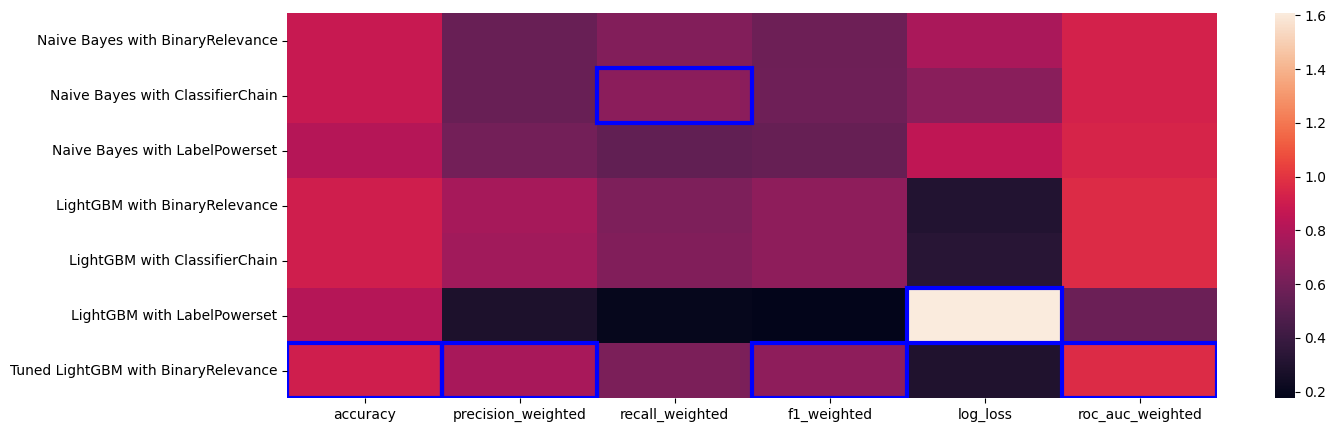

In [37]:
# identify the best performance for each evaluation score
fig,ax = plt.subplots(figsize=(15, 5), facecolor='w', edgecolor='k')
ax = sns.heatmap(scores_collection_combined.drop('model name', axis=1), yticklabels=scores_collection_combined['model name'])
column_best = scores_collection_combined.drop('model name', axis=1).idxmax(axis=0)

for col, variable in enumerate(scores_collection_combined.columns[1:]):
    position = scores_collection_combined.index.get_loc(column_best[variable])
    ax.add_patch(Rectangle((col, position),1,1, fill=False, edgecolor='blue', lw=3))